<a href="https://colab.research.google.com/github/MohamedWah1d/Expenses-app/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.dates as md
import matplotlib.pyplot as plt
import os
import math
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation
from keras.layers import LSTM
from keras.optimizers import Adam,RMSprop
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Conv2D, MaxPooling2D,MaxPooling1D

In [229]:
EGX30 = pd.read_csv('updated_data.csv',parse_dates=['Date'])

In [230]:
#Original data
EGX30

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-21,"29,054.96","31,013.88","29,094.10","28,280.76",258.51M,1.63%
1,2024-03-20,"28,589.37","28,675.70","29,229.67","28,542.99",177.70M,-0.30%
2,2024-03-19,"28,675.70","29,091.29","29,091.29","28,167.52",206.62M,-1.43%
3,2024-03-18,"29,091.29","31,061.88","31,065.50","29,091.29",250.35M,-6.34%
4,2024-03-17,"31,061.88","31,316.43","31,781.24","31,061.88",260.29M,-0.81%
...,...,...,...,...,...,...,...
4927,2004-01-11,"1,212.67","1,212.95","1,217.53","1,208.08",NaN,-0.03%
4928,2004-01-08,"1,212.99","1,228.07","1,240.18","1,212.95",NaN,-1.23%
4929,2004-01-06,"1,228.07","1,191.84","1,228.07","1,191.84",NaN,3.04%
4930,2004-01-05,"1,191.81","1,173.79","1,191.84","1,173.79",NaN,1.54%


In [231]:
#read the data
dataframe = pd.read_csv('updated_data.csv', usecols=['Price'], index_col=False)

In [232]:
dataframe

,Price
0,"29,054.96"
1,"28,589.37"
2,"28,675.70"
3,"29,091.29"
4,"31,061.88"
...,...
4927,"1,212.67"
4928,"1,212.99"
4929,"1,228.07"
4930,"1,191.81"


In [233]:
#Change the name of the price column to close.
dataframe.rename(columns={'Price': 'Close'}, inplace=True)

dataframe = dataframe.dropna()

In [234]:
dataframe

,Close
0,"29,054.96"
1,"28,589.37"
2,"28,675.70"
3,"29,091.29"
4,"31,061.88"
...,...
4927,"1,212.67"
4928,"1,212.99"
4929,"1,228.07"
4930,"1,191.81"


In [235]:
# Define a function to convert million (M) and billion (B) suffixes
def convert_to_number(s):
    if s.endswith('M'):
        return float(s.replace('M', '')) * 1e6
    elif s.endswith('B'):
        return float(s.replace('B', '')) * 1e9
    else:
        return float(s)

In [236]:
# Remove commas and dots, then convert to float
dataframe['Close'] = dataframe['Close'].str.replace(',', '').astype(float)

In [237]:
dataframe

,Close
0,29054.96
1,28589.37
2,28675.70
3,29091.29
4,31061.88
...,...
4927,1212.67
4928,1212.99
4929,1228.07
4930,1191.81


In [238]:
#Sorting the data from old to new
dataframe = dataframe[::-1]

In [239]:
dataframe

,Close
4931,1173.76
4930,1191.81
4929,1228.07
4928,1212.99
4927,1212.67
...,...
4,31061.88
3,29091.29
2,28675.70
1,28589.37


In [240]:
#Modifying the index to follow the right pattern.
dataframe = dataframe.reset_index(drop=True)

In [241]:
dataframe

,Close
0,1173.76
1,1191.81
2,1228.07
3,1212.99
4,1212.67
...,...
4927,31061.88
4928,29091.29
4929,28675.70
4930,28589.37


In [242]:
# fix random seed for reproducibility
np.random.seed(42)

In [243]:
# normalize the dataset
dataset = dataframe.values

In [244]:
dataset

array([[ 1173.76],
       [ 1191.81],
       [ 1228.07],
       ...,
       [28675.7 ],
       [28589.37],
       [29054.96]])

In [245]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [246]:
dataset.shape

(4932, 1)

In [247]:
#Splitting the data to be 80% training and 20% for testing
print(len(dataset))
train_size = int(len(dataset)-987)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4932
3945 987


In [248]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [249]:
# reshape into X=t and Y=t+1
look_back = 2
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [250]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [251]:
X_train.shape

(3942, 1, 2)

In [252]:
X_test.shape

(984, 1, 2)

In [253]:
print(X_train.shape)
x_train2 = X_train.reshape((3942,2,1))
print(x_train2.shape)
print(y_train.shape)
print(X_test.shape)
x_test2 = X_test.reshape((984,2,1))

(3942, 1, 2)
(3942, 2, 1)
(3942,)
(984, 1, 2)


In [254]:
#Now creating the model.
cnn = Sequential()
cnn.add(Conv1D(4, kernel_size=2, strides=1,padding='same',
                 activation='relu',
                 input_shape=(2,1)))
cnn.add(MaxPooling1D(pool_size=2))

cnn.add(Flatten())
cnn.add(Dense(30))

cnn.add(Dense(1))
cnn.summary()
cnn.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 2, 4)              12        
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 4)              0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 4)                 0         
                                                                 
 dense_22 (Dense)            (None, 30)                150       
                                                                 
 dense_23 (Dense)            (None, 1)                 31        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_______________

In [255]:
cnn.fit(x_train2,y_train, batch_size=4,verbose=2,epochs=100)
# cnn.fit(x_train2, y_train, validation_data=(x_test2, y_test), callbacks=[monitor,checkpointer],verbose=2, epochs=25)

Epoch 1/100
986/986 - 4s - loss: 6.2712e-05 - 4s/epoch - 4ms/step
Epoch 2/100
986/986 - 3s - loss: 2.4452e-05 - 3s/epoch - 3ms/step
Epoch 3/100
986/986 - 3s - loss: 2.3906e-05 - 3s/epoch - 3ms/step
Epoch 4/100
986/986 - 2s - loss: 2.1980e-05 - 2s/epoch - 2ms/step
Epoch 5/100
986/986 - 2s - loss: 2.3018e-05 - 2s/epoch - 3ms/step
Epoch 6/100
986/986 - 3s - loss: 2.3376e-05 - 3s/epoch - 3ms/step
Epoch 7/100
986/986 - 2s - loss: 2.4336e-05 - 2s/epoch - 2ms/step
Epoch 8/100
986/986 - 2s - loss: 2.0973e-05 - 2s/epoch - 2ms/step
Epoch 9/100
986/986 - 2s - loss: 2.5101e-05 - 2s/epoch - 2ms/step
Epoch 10/100
986/986 - 3s - loss: 2.0513e-05 - 3s/epoch - 3ms/step
Epoch 11/100
986/986 - 3s - loss: 2.2816e-05 - 3s/epoch - 3ms/step
Epoch 12/100
986/986 - 2s - loss: 2.2746e-05 - 2s/epoch - 2ms/step
Epoch 13/100
986/986 - 2s - loss: 2.1843e-05 - 2s/epoch - 3ms/step
Epoch 14/100
986/986 - 2s - loss: 2.0187e-05 - 2s/epoch - 2ms/step
Epoch 15/100
986/986 - 3s - loss: 1.9985e-05 - 3s/epoch - 3ms/step
Epoc

In [259]:
trainPredict = cnn.predict(x_train2)
testPredict = cnn.predict(x_test2)
# invert predictions
# print(trainPredict)
trainPredict = scaler.inverse_transform(trainPredict)
print(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error

31/31 [==============================] - 0s 2ms/step
[[ 1362.9468]
 [ 1362.9468]
 [ 1362.9468]
 ...
 [13413.289 ]
 [13285.608 ]
 [13093.769 ]]


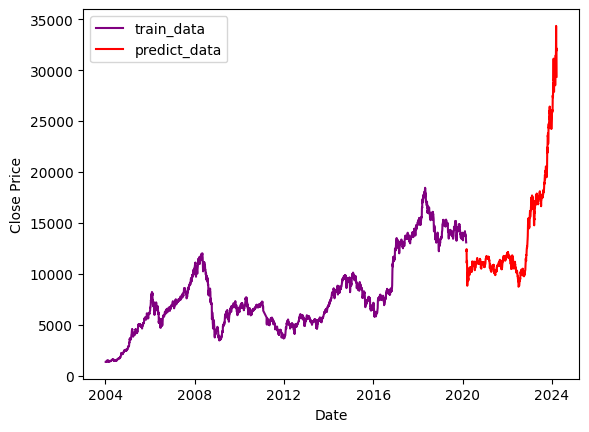

In [270]:
# shift train predictions for plotting
dataframe1 = pd.read_csv('updated_data.csv', usecols=['Date'], index_col=False)
dataframe1 = dataframe1[::-1]

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

# plt.plot(scaler.inverse_transform(dataset))
plt.plot(pd.to_datetime(dataframe1['Date']),trainPredictPlot, color='purple',label='train_data')
plt.plot(pd.to_datetime(dataframe1['Date']),testPredictPlot, color='red',label='predict_data')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

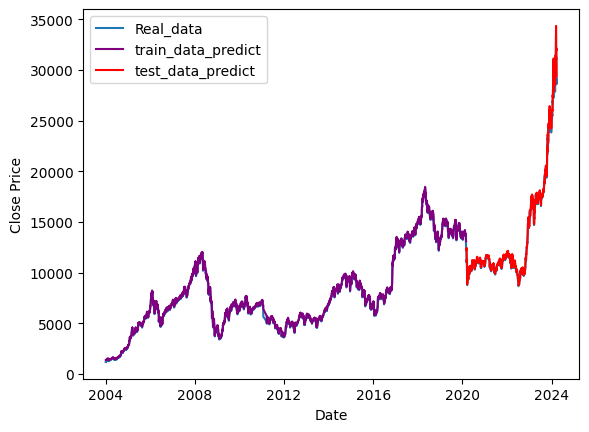

In [271]:
dataframe1 = pd.read_csv('updated_data.csv', usecols=['Date'], index_col=False)
dataframe1 = dataframe1[::-1]

dataframe1 = dataframe1.reset_index(drop=True)
dataframe1
plt.plot(pd.to_datetime(dataframe1['Date']), scaler.inverse_transform(dataset),label='Real_data')
plt.plot(pd.to_datetime(dataframe1['Date']),trainPredictPlot, color='purple',label='train_data_predict')
plt.plot(pd.to_datetime(dataframe1['Date']),testPredictPlot, color='red',label='test_data_predict')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend()

plt.show()